In [1]:
# List of questions and to be done items that are not obvious
# Difference in the number of sources in a query with and without limit
# how do I learn what flags are?
#

# Explore AuxTel Prompt Processing Subtractions + APDB
Neven Caplar 
Started: 2023-09-12

Goals:

References
1. Track Prompt Processing AuxTel runs here  
    https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023  

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import astropy.units as u
from astropy.time import Time

# run before notebook: 'source /sdf/group/rubin/sw/loadLSST.bash'
# add also -
# lsst.analysis.ap not yet in lsst distrib, just a dm package
# so github clone from https://github.com/lsst/analysis_ap
# and add to your notebooks/.user_setups
# setup -k -r <PATH_To_Directory>/analysis_ap
#

# AP LSST import
from lsst.analysis.ap import apdb, CutoutPath

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [39]:
# all of the other lsst imports
import lsst.afw.display as afwDisplay
from lsst.analysis.tools.actions.vector import ConvertUnits, FlagSelector, GoodDiaSourceSelector, LoadVector
from lsst.analysis.tools.atools import SkySourceHistPlot, SkySourceSkyPlot, NumDiaSourcesAllMetric, NumDiaSourcesMetric, NumDipolesMetric
import lsst.daf.butler as dafButler
from lsst.daf.butler import DataCoordinate
import lsst.geom as geom

from IPython.display import Image, display
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

## Create lightcurves 

In [40]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)
schema = 'pp_apdb'
instrument = 'LATISS'
apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)
sources = apdbQuery.load_sources()

# For reasons that I do not understand this produces less rows (67953 on Sep 09, 2023) than query without limit (100_000)
sources_67 = apdbQuery.load_sources(1000007)
len(sources_67)

sources_cortado = sources[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]


# replacing visit value with correct values
# see this slack discussion https://lsstc.slack.com/archives/C2B6X08LS/p1694212674366649?thread_ts=1694211760.066429&cid=C2B6X08LS
# Specific Dimension Packer 
from lsst.obs.lsst import RubinDimensionPacker
# The constructor data ID has the dimensions that must not change
packer = RubinDimensionPacker(DataCoordinate.standardize({"instrument": 'LATISS'}, universe=butler.dimensions), config=RubinDimensionPacker.ConfigClass(), is_exposure=False)
packer.pack({"instrument": 'LATISS', "detector": 0, "visit": 2023072000156})
dataId = DataCoordinate.standardize({"instrument": 'LATISS', "detector": 0, "visit": 2023072000156}, universe=butler.dimensions)
packer.pack(dataId)  # Both work
packer.unpack(41506872320)


unpacked_val = list(map(packer.unpack,sources_cortado['visit'].values))
visit_values = np.array([item['visit'] for item in unpacked_val])
sources_cortado = sources_cortado.assign(visit=visit_values)

In [41]:
sources_cortado

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,scienceFlux,scienceFluxErr,snr,band,flags,visit
0,174092440599265514,174092440599265514,240.038143,-24.101019,1627.205933,37.985645,60146.030187,-1.369311e+05,29929.066308,5.328640,r,8388940,2023072000156
1,174092440599265515,174092440599265515,240.052834,-24.100725,2131.843262,42.388309,60146.030187,-1.295897e+05,32173.370990,5.606334,r,8388940,2023072000156
2,174092440599265516,174092440599265516,240.081363,-24.099736,3112.010986,66.503075,60146.030187,-1.224625e+05,33796.369878,5.078874,r,4,2023072000156
3,174092440599265517,174092440599265517,240.068013,-24.099359,2653.764893,86.822998,60146.030187,2.188439e+05,34788.452217,7.006915,r,8388940,2023072000156
4,174092440599265518,174092440599265518,240.023533,-24.099858,1126.073242,88.252174,60146.030187,1.833681e+05,31596.952247,6.509221,r,332,2023072000156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,175500090360726048,175500090360726048,270.215580,-24.998545,463.778172,302.791018,60186.158159,-1.469748e+04,6161.393213,9.807353,g,8388608,2023082900412
99996,175500090360726049,175500090360726049,270.218538,-24.997548,565.134338,339.048828,60186.158159,-2.429261e+04,6244.606738,5.050261,g,0,2023082900412
99997,175500090360726050,175500087139500409,270.289140,-24.996895,2973.092041,334.051941,60186.158159,7.216402e+05,7738.108420,11.812448,g,8388608,2023082900412
99998,175500090360726051,175077969163715308,270.219737,-24.995496,606.964844,415.760132,60186.158159,-3.245159e+04,6556.591913,5.959670,g,8388940,2023082900412


In [42]:
"""
Schema says: 
https://github.com/lsst/sdm_schemas/blob/0d3fc262d112470a76879c0bc2f2b8d1b6adabd3/yml/apdb.yaml#L2145

- name: scienceFlux
"@id": "#DiaSource.scienceFlux"
datatype: float
description: Forced photometry flux for a point source model measured on the visit image
  centered at DiaSource position.
mysql:datatype: FLOAT
fits:tunit: nJy
ivoa:ucd: phot.count
"""
# add a column with brightness
# sources_cortado['mag'] = (sources_cortado['scienceFlux']).values*u.nJy.to(u.ABmag) / this seems to be wrong
sources_cortado['mag'] = u.nJy.to(u.ABmag, sources_cortado['scienceFlux'])

# add a column with error estimate for brightness 
upper_mag = u.nJy.to(u.ABmag, sources_cortado['scienceFlux']+sources_cortado['scienceFluxErr'])
lower_mag = u.nJy.to(u.ABmag, sources_cortado['scienceFlux']-sources_cortado['scienceFluxErr'])
magErr = -(upper_mag-lower_mag)/2
sources_cortado['magErr'] = magErr

### Investigating the difference between the query with with and without limit 

Text(0, 0.5, 'dec')

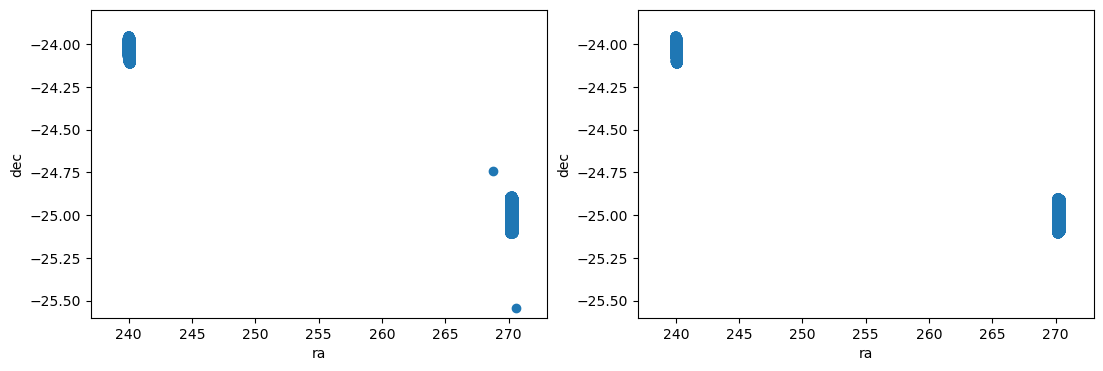

In [43]:
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.scatter(sources['ra'],sources['dec'])
plt.xlim(237,273)
plt.ylim(-25.6,-23.8)
plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.scatter(sources_67['ra'],sources_67['dec'])
plt.xlim(237,273)
plt.ylim(-25.6,-23.8)
plt.xlabel('ra')
plt.ylabel('dec')

In [44]:
# why is there a difference
# there is a difference in a number of unique sources
print(len(np.unique(sources['diaObjectId'])))
print(len(np.unique(sources_67['diaObjectId'])))

# Question -> unsolved at this point

59052
36856


## Looking at lightcurves

In [45]:
# what are the flags that are present in the data
# how do I learn what these flags are?
np.unique(sources['flags'], return_counts=True)

(array([       0,        4,       40,       44,       76,      108,
             332,      364,      528,     1320,     1324,     1388,
          131076,   131148,  8388608,  8388612,  8388648,  8388652,
         8388684,  8388716,  8388732,  8388940,  8388972,  8389136,
         8389140,  8389176,  8389180,  8389212,  8389244,  8389432,
         8389928,  8389996,  8519684,  8519756,  8519788, 41943040,
        41943044, 41943080, 41943116, 41943148, 41943296, 41943300,
        41943336, 41943372, 41943404, 41944320, 47841284, 47874054,
        47939584, 47939590, 47939660, 47939662, 50233350, 50233422]),
 array([35163, 10785,   148,    49,  5237,    46,  9528,    35,     2,
           21,     1,     2,     9,     1, 12663,  1096,   160,    16,
         4131,   287,     1, 19007,   239,     7,     1,     1,     1,
            7,     4,     2,    74,    15,     3,     2,     2,   620,
           64,     3,   315,     5,    77,     8,     1,   130,     1,
            1,     1,     2,   

In [46]:
# select only the one where the flag is 0
sources_cortado = sources_cortado[sources_cortado['flags']==0]

In [47]:
# number of observations for each object
# there must be a better way
uniq_obj = np.unique(sources_cortado['diaObjectId'])

list_of_len_sources = []
for diaObjectId in uniq_obj:
    try:
        sources_select = sources_cortado[sources_cortado['diaObjectId'] ==  diaObjectId]
        list_of_len_sources.append([sources_select['diaObjectId'].iloc[0],len(sources_select)])
    except:
        pass
    
array_of_len_sources = np.array(list_of_len_sources)

# Select the lightcurve with more than 20 observations
array_of_len_sources_20 = array_of_len_sources[array_of_len_sources[:,1]>20]

In [48]:
sources_cortado_select = sources_cortado[sources_cortado['diaObjectId'] ==  array_of_len_sources_20[10][0]]
sources_cortado_select

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,scienceFlux,scienceFluxErr,snr,band,flags,visit,mag,magErr
47626,175077939098944665,174092445967975104,270.269620,-24.989944,2831.579691,3605.725691,60174.164930,1.829855e+06,11168.764230,5.545234,i,0,2023081700469,15.743958,0.006627
48039,175077940172686126,174092445967975104,270.269639,-24.989806,2840.683838,3608.997559,60174.165443,4.274084e+05,7356.590230,14.481459,g,0,2023081700470,17.322892,0.018690
57761,175077964868748093,174092445967975104,270.269596,-24.989859,3378.368408,2481.588867,60174.178106,1.487327e+06,10452.603619,6.113983,i,0,2023081700493,15.968984,0.007630
58166,175077965942489781,174092445967975104,270.269549,-24.989770,3381.075439,2486.004395,60174.178620,4.287367e+05,8676.784347,10.040241,g,0,2023081700494,17.319523,0.021976
58514,175077967016231553,174092445967975104,270.269447,-24.989927,3373.784180,2479.340332,60174.179133,8.622626e+05,9625.960919,13.091816,r,0,2023081700495,16.560901,0.012121
58928,175077968089973495,174092445967975104,270.269663,-24.989791,2822.134766,2492.104004,60174.179768,8.043546e+05,9540.643012,5.436218,r,0,2023081700496,16.636381,0.012879
59341,175077969163715331,174092445967975104,270.269467,-24.989852,2822.074951,2486.888916,60174.180281,4.332779e+05,8255.663986,5.020926,g,0,2023081700497,17.308084,0.020690
64254,175077982048617108,174092445967975104,270.269586,-24.989845,3922.257812,1359.573730,60174.186900,6.112120e+05,9493.286799,7.923247,g,0,2023081700509,16.934520,0.016865
65156,175077984196100869,174092445967975104,270.269514,-24.989832,3357.322021,1369.240723,60174.188083,9.325966e+05,11761.755096,6.064835,i,0,2023081700511,16.475765,0.013694
65918,175077986343584242,174092445967975104,270.269555,-24.989881,3359.697510,1365.025269,60174.189109,9.520722e+05,15910.896343,10.057852,r,0,2023081700513,16.453325,0.018146


Text(0, 0.5, 'science flux [nJy]')

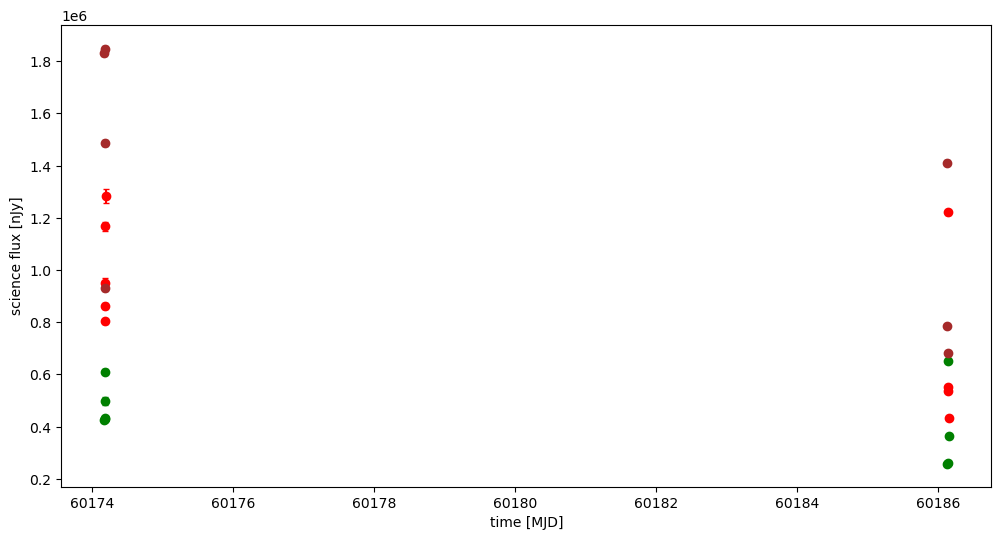

In [49]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['scienceFlux'],yerr=sources_cortado_select_sband['scienceFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    
plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy]')

Text(0, 0.5, 'science brightness [mag]')

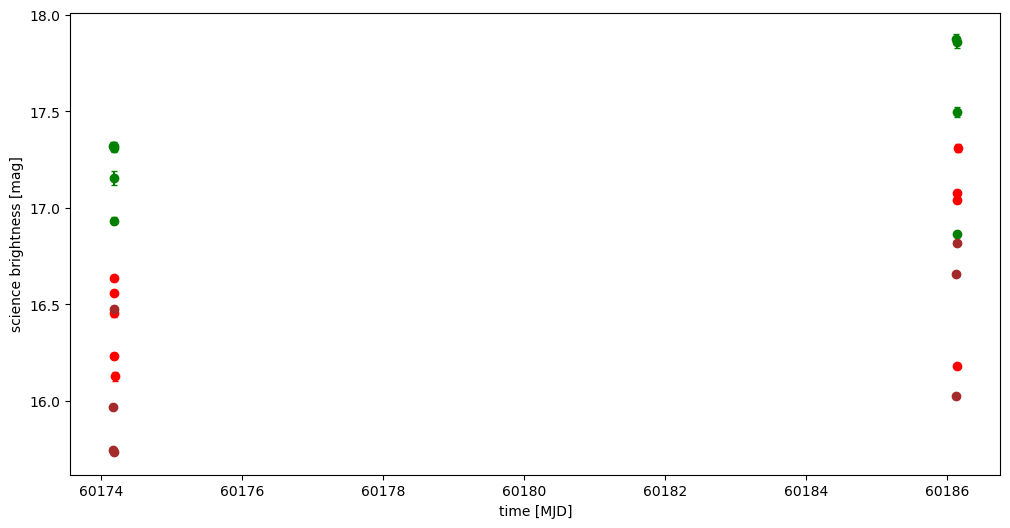

In [50]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['mag'],yerr=sources_cortado_select_sband['magErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    
plt.xlabel('time [MJD]')
plt.ylabel('science brightness [mag]')

## look at the single visit, single cutout

In [ ]:
# let us try to get image from visit from 2023081700470

In [23]:
# This information can be also found here: https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023
! butler query-collections /sdf/group/rubin/repo/embargo "LATISS/prompt/*-2023-0*/ApPipe/*"


                               Name                               Type
----------------------------------------------------------------- ----
LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026 RUN 
LATISS/prompt/output-2023-05-25/ApPipe/prompt-proto-service-00027 RUN 
LATISS/prompt/output-2023-07-20/ApPipe/prompt-proto-service-00007 RUN 
LATISS/prompt/output-2023-08-15/ApPipe/prompt-proto-service-00010 RUN 
LATISS/prompt/output-2023-08-16/ApPipe/prompt-proto-service-00011 RUN 
LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 RUN 
LATISS/prompt/output-2023-08-29/ApPipe/prompt-proto-service-00013 RUN 


In [51]:
# Start with some time in modified julian date (MJD)
mjd = 60174.165443

# Convert to Julian Date
jd = mjd + 2400000.5

# Convert to astropy Time object
t = Time(jd, format='jd')

# Convert to datetime
utc = t.to_datetime()
utc

datetime.datetime(2023, 8, 18, 3, 58, 14, 275193)

In [52]:
! butler query-datasets /sdf/group/rubin/repo/embargo \
    --collections "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011" \
    --where "instrument='LATISS' and detector=0 and band='g' and visit >= 2023081700470 and visit <= 2023081700470" \
    deepDiff_differenceExp


         type                                         run                                                 id                  band instrument detector physical_filter      visit    
---------------------- ----------------------------------------------------------------- ------------------------------------ ---- ---------- -------- ---------------- -------------
deepDiff_differenceExp LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 c8def79d-ab38-47c4-a5d7-dd65cfc0a797    g     LATISS        0 SDSSg_65mm~empty 2023081700470



In [56]:
ap_collection = "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011"
data_id = {"instrument": "LATISS", "detector": 0, "band": "g", "visit": 2023081700470}

calexp = butler.get("calexp", dataId=data_id, collections=ap_collection)
diff = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
template = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
matched_template = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)

# Includes detections and sky sources. Direct output from detect+measure after image subtraction.
diaSrc = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
# The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
diaSrcTable = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)

calexp

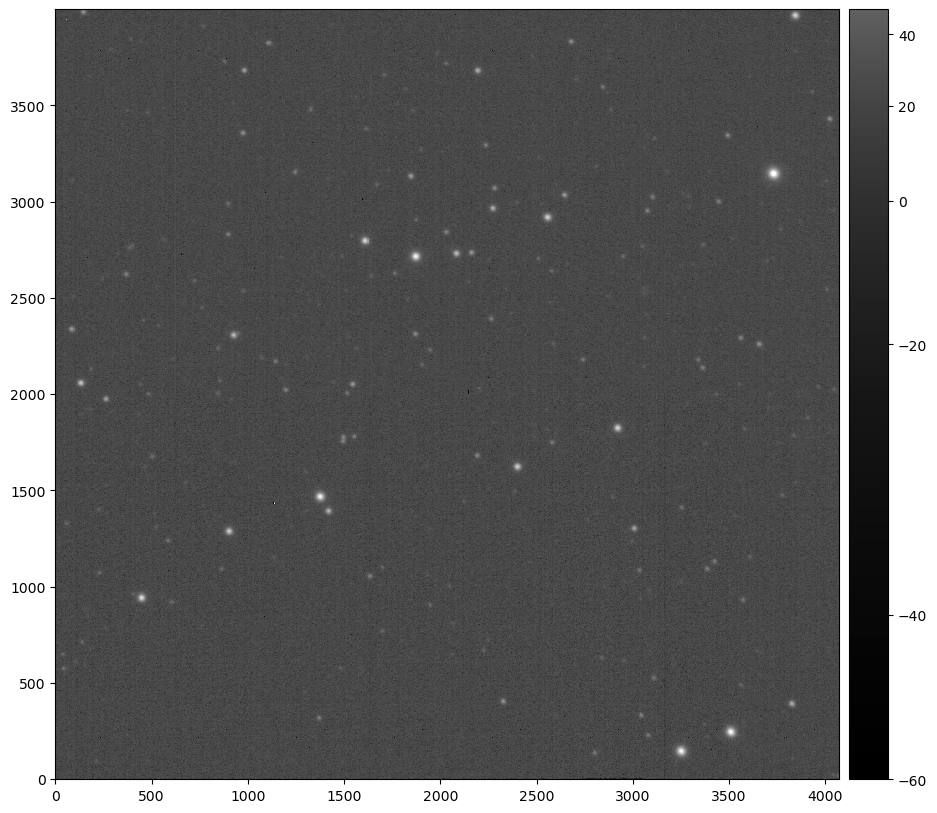

In [57]:
fig = plt.figure(figsize=(12, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()

In [67]:
def show_cutout_triplet(template, science, diff, x, y, size=30, figsize=(16, 8)):
    """
    Create and show a cutout of an template, science and difference image
    given a position
    """
    xy = geom.PointI(x, y)
    cutoutSize = geom.ExtentI(size, size)
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)

    template_cutout = template.getCutout(bbox)
    science_cutout = science.getCutout(bbox)
    diff_cutout = diff.getCutout(bbox)

    # Use diff sigma for calexp, diff ranges.
    sigma = np.sqrt(np.median(diff.variance.array))

    fit, axes = plt.subplots(1, 3, figsize=figsize)
    plt.sca(axes[0])
    plt.imshow(template_cutout.image.array, cmap="gray", origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Template")
    plt.sca(axes[1])
    plt.imshow(science_cutout.image.array, cmap="gray", vmin=-5*sigma, vmax=+5*sigma, origin='lower')
    plt.title("Science")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.sca(axes[2])
    plt.imshow(diff_cutout.image.array, cmap="gray", vmin=-5*sigma, vmax=+5*sigma, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Diff")

2840.683837890625 3608.99755859375


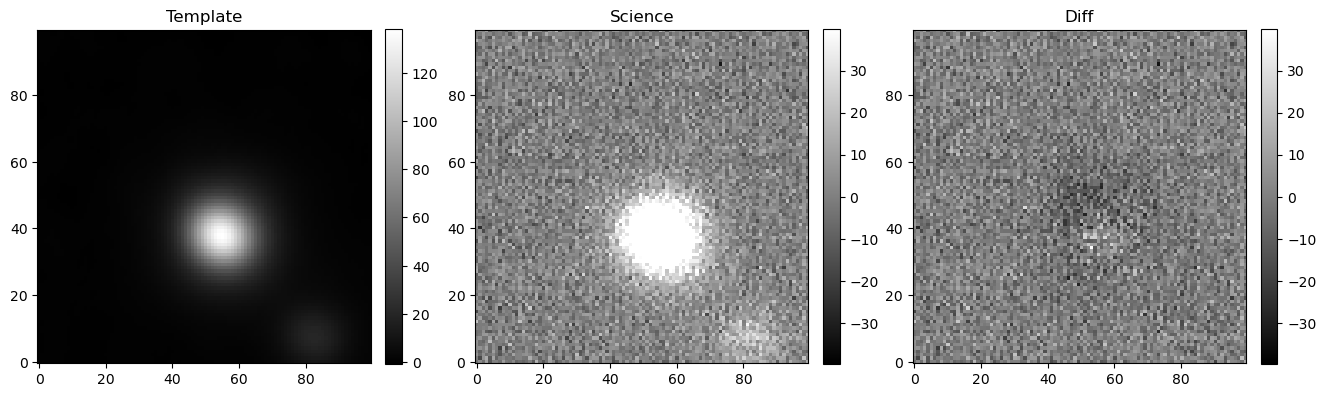

In [68]:
stamp_size = 100 # pixels.  Size of baseline alert stamp
x = sources_cortado_select.loc[48039]['x']
y = sources_cortado_select.loc[48039]['y']

print(x, y)
show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size)

In [37]:
sources_cortado_select.loc[48039]

diaSourceId       175077940172686126
diaObjectId       174092445967975104
ra                        270.269639
dec                       -24.989806
midpointMjdTai          60174.165443
scienceFlux            427408.388508
scienceFluxErr            7356.59023
snr                        14.481459
band                               g
flags                              0
visit                  2023081700470
mag                        17.322892
magErr                       0.01869
Name: 48039, dtype: object